# <a id='toc1_'></a>[Sabrina del Rosal](#toc0_)
## <a id='toc1_1_'></a>[Further EDA and Modelling for Predictions of Injury in UK Racehorses](#toc0_)

Jupyter Notebook: Sprint 1 uncovered learnings regarding data quality, feature engineering and other preprocessing concerns. In sprint 2 you will incorporate your learnings to prepare your dataset for modeling. You will also conduct a more thorough round of EDA, addressing questions you formulated upon taking a first pass over the data in Sprint 1. In addition to preprocessing and EDA, this notebook should include baseline models to set the stage for advanced modeling in the final sprint. As you develop baseline models, it is also important to articulate a model evaluation framework that accurately reflects the practical use case of your models.

**Table of contents**<a id='toc0_'></a>    
- [Sabrina del Rosal](#toc1_)    
  - [Further EDA and Modelling for Predictions of Injury in UK Racehorses](#toc1_1_)    
  - [Sprint 2:](#toc1_2_)    
    - [Further EDA](#toc1_2_1_)    
      - [Subset of Horses with No Injuries](#toc1_2_1_1_)    
      - [Analyzing Their Track Conditions](#toc1_2_1_2_)    
      - [Their Seasonality in Racing](#toc1_2_1_3_)    
    - [Preprocessing for Modelling](#toc1_2_2_)    
      - [Cleaning up DataFrame](#toc1_2_2_1_)    
      - [Train - Test Split](#toc1_2_2_2_)    
    - [Baseline Models](#toc1_2_3_)    
      - [Logistic Regression Model: Predicting Horse Racing positions (focused on position = 0)](#toc1_2_3_1_)    
      - [Decision Tree: Classification Model Predicting Risk of Injury (focused on class = 1)](#toc1_2_3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_2_'></a>[Sprint 2:](#toc0_)

**Downloading Data**

In [325]:
# import any necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier

In [326]:
# importing data

races_horses_target_df = pd.read_csv("../data/races_horses_target_df.csv")


twentyfiveplus_horses = pd.read_csv("../data/twentyfiveplus_horses.csv")


### <a id='toc1_2_1_'></a>[Further EDA](#toc0_)

#### <a id='toc1_2_1_1_'></a>[Subset of Horses with No Injuries](#toc0_)

In [327]:
# EDA on "exceptional" horses subset

races_horses_target_df.head()

,rid,horseName,age,saddle,position,TR,OR,weight,res_win,res_place,date,hurdles,winningTime,metric,ncond,class,fences,RiskOfInjury,DaysRested,RacesRun
0,331875,A And Jay,3,9.0,9,54,0,51,0.0,0,2000-10-28,0,109.60,1609.0,9,0,0,0,NaN,1
1,196779,A B My Boy,2,1.0,6,54,0,54,0.0,0,2000-04-13,0,65.20,1105.5,10,4,0,0,NaN,1
2,383212,A B My Boy,2,1.0,7,54,0,54,0.0,0,2000-05-04,0,61.50,1105.5,2,4,0,0,21.0,2
3,90359,A B My Boy,2,2.0,9,54,0,53,0.0,0,2000-05-20,0,73.69,1206.0,1,6,0,0,16.0,3
4,84566,A B My Boy,2,1.0,6,54,0,53,0.0,0,2000-06-01,0,77.65,1206.0,10,5,0,0,12.0,4


In [328]:
# looking at our data

twentyfiveplus_horses.head()

,horseName,TotalRaces,InjuryRisk
0,Absolute Fantasy,27,0
1,Cauda Equina,27,0
2,Classy Cleo,27,0
3,Dahlidya,26,0
4,Distinctive Dream,28,0


In [329]:
# grab the 25 plus horses full df's

twentyfivehorses = list(twentyfiveplus_horses["horseName"])


twentyfive_horses_df = races_horses_target_df[races_horses_target_df["horseName"].isin(twentyfivehorses)]

In [330]:
# sanity check

twentyfive_horses_df.head()

,rid,horseName,age,saddle,position,TR,OR,weight,res_win,res_place,date,hurdles,winningTime,metric,ncond,class,fences,RiskOfInjury,DaysRested,RacesRun
362,357816,Absolute Fantasy,4,4.0,6,1,49,58,0.0,0,2000-01-05,0,99.69,1609.0,0,4,0,0,NaN,1
363,356905,Absolute Fantasy,4,3.0,2,38,44,57,0.0,1,2000-01-26,0,73.43,1206.0,0,4,0,0,21.0,2
364,286953,Absolute Fantasy,4,3.0,6,5,47,57,0.0,0,2000-02-07,0,78.80,1206.0,0,4,0,0,12.0,3
365,67171,Absolute Fantasy,4,5.0,8,17,44,54,0.0,0,2000-03-04,0,72.65,1206.0,0,6,0,0,26.0,4
366,369177,Absolute Fantasy,4,14.0,2,33,35,55,0.0,1,2000-03-30,0,87.30,1407.0,1,6,0,0,26.0,5


#### <a id='toc1_2_1_2_'></a>[Analyzing Their Track Conditions](#toc0_)

In [331]:
# sorting track conditions

# total races per ncond
totalraces = twentyfive_horses_df["ncond"].value_counts()

# 0 = standard or NaN condition (most common would be standard which means that "In UK horse racing, 
# "Standard" is a track condition used for All-Weather (AW) racing (synthetic surfaces like Polytrack, Tapeta, or Fibresand). It indicates a normal racing surface, 
# neither too fast nor too slow.")

/var/folders/y9/047nsvmd0f78b5tp5d55l6hw0000gn/T/ipykernel_33670/1016524050.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(x=totalraces.index, y=totalraces.values , order=totalraces.index).set_xticklabels(conditions)


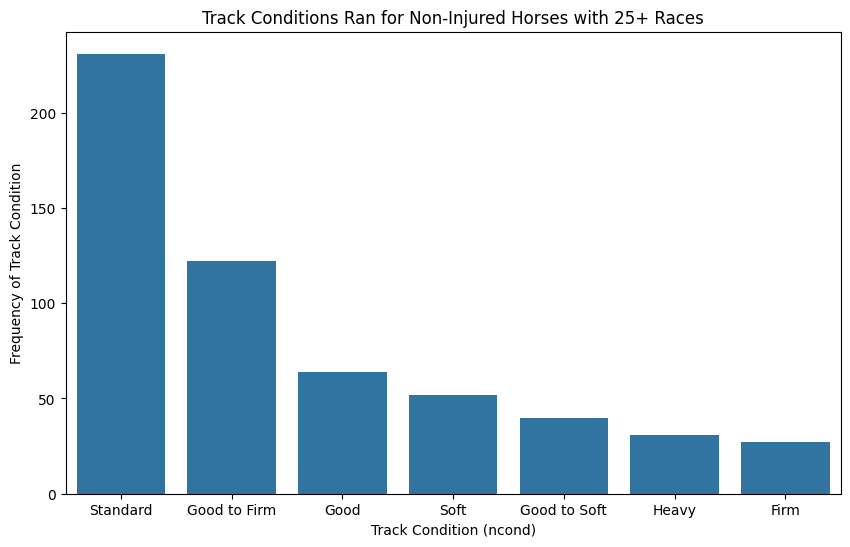

In [332]:
# plotting track conditions of all 25 non-injured horses 

conditions = ["Standard" , "Good to Firm" , "Good" , "Soft" , "Good to Soft" , "Heavy" , "Firm"]

plt.figure(figsize=(10, 6))

sns.barplot(x=totalraces.index, y=totalraces.values , order=totalraces.index).set_xticklabels(conditions)
plt.title("Track Conditions Ran for Non-Injured Horses with 25+ Races")
plt.xlabel("Track Condition (ncond)")
plt.ylabel("Frequency of Track Condition")

plt.show()


# 0 = standard , 2 = good to firm , 1 = good , 5 = soft , 10 = good to soft, 9 = heavy , 8 = firm


# we so no soft to heavy which was high for injury BUT goot to soft and soft are here (minimal) which were top 3 in injury risk

#### <a id='toc1_2_1_3_'></a>[Their Seasonality in Racing](#toc0_)

In [333]:
# more EDA if time allows and write up insights

### <a id='toc1_2_2_'></a>[Preprocessing for Modelling](#toc0_)

#### <a id='toc1_2_2_1_'></a>[Cleaning up DataFrame](#toc0_)

In [334]:
# sanity check 

races_horses_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105435 entries, 0 to 105434
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   rid           105435 non-null  int64  
 1   horseName     105435 non-null  object 
 2   age           105435 non-null  int64  
 3   saddle        105435 non-null  float64
 4   position      105435 non-null  int64  
 5   TR            105435 non-null  int64  
 6   OR            105435 non-null  int64  
 7   weight        105435 non-null  int64  
 8   res_win       105435 non-null  float64
 9   res_place     105435 non-null  int64  
 10  date          105435 non-null  object 
 11  hurdles       105435 non-null  int64  
 12  winningTime   105435 non-null  float64
 13  metric        105435 non-null  float64
 14  ncond         105435 non-null  int64  
 15  class         105435 non-null  int64  
 16  fences        105435 non-null  int64  
 17  RiskOfInjury  105435 non-null  int64  
 18  Days

In [335]:
races_horses_target_df.describe()

,rid,age,saddle,position,TR,OR,weight,res_win,res_place,hurdles,winningTime,metric,ncond,class,fences,RiskOfInjury,DaysRested,RacesRun
count,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,105435.000000,83087.000000,105435.000000
mean,222561.609276,5.108436,7.374800,6.210442,54.505316,48.077669,61.252734,0.090615,0.259933,2.354636,191.962105,2652.618277,4.240214,3.109290,2.054033,0.077052,30.249389,4.381524
std,119016.940375,2.345969,5.041225,4.846308,22.360412,40.168695,7.815255,0.287062,0.438599,4.292229,107.115326,1251.601640,3.686826,2.166429,5.447060,0.266676,39.305003,3.568141
min,105.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1005.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,99790.000000,3.000000,3.000000,2.000000,50.000000,0.000000,55.000000,0.000000,0.000000,0.000000,93.110000,1407.000000,1.000000,0.000000,0.000000,0.000000,11.000000,2.000000
50%,243399.000000,5.000000,6.000000,5.000000,54.000000,55.000000,60.000000,0.000000,0.000000,0.000000,160.800000,2413.000000,2.000000,4.000000,0.000000,0.000000,18.000000,3.000000
75%,321025.000000,7.000000,10.000000,9.000000,57.000000,79.000000,68.000000,0.000000,1.000000,0.000000,270.600000,3519.500000,8.000000,5.000000,0.000000,0.000000,31.000000,6.000000
max,401362.000000,17.000000,40.000000,35.000000,186.000000,177.000000,80.000000,1.000000,1.000000,16.000000,564.700000,7240.000000,18.000000,6.000000,32.000000,1.000000,359.000000,37.000000


#### <a id='toc1_2_2_2_'></a>[Train - Test Split](#toc0_)

In [336]:
# features

X = races_horses_target_df.drop(['horseName' , 'position' , 'res_win' , 'res_place' , 'DaysRested' , 'RiskOfInjury'], axis=1) # position is too similar to target

# target variable

y = races_horses_target_df['RiskOfInjury']  

In [337]:
# sanity check 

X.head()

,rid,age,saddle,TR,OR,weight,date,hurdles,winningTime,metric,ncond,class,fences,RacesRun
0,331875,3,9.0,54,0,51,2000-10-28,0,109.60,1609.0,9,0,0,1
1,196779,2,1.0,54,0,54,2000-04-13,0,65.20,1105.5,10,4,0,1
2,383212,2,1.0,54,0,54,2000-05-04,0,61.50,1105.5,2,4,0,2
3,90359,2,2.0,54,0,53,2000-05-20,0,73.69,1206.0,1,6,0,3
4,84566,2,1.0,54,0,53,2000-06-01,0,77.65,1206.0,10,5,0,4


In [338]:
# splitting data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [339]:
# convert to date to numerical column for modeling

X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

# days since the minimum date

X_train['days_since'] = (X_train['date'] - X_train['date'].min()).dt.days
X_test['days_since'] = (X_test['date'] - X_test['date'].min()).dt.days

# drop the original 'date' column

X_train.drop(columns=['date'], inplace=True)
X_test.drop(columns=['date'], inplace=True)


In [340]:
# scaling my data
 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### <a id='toc1_2_3_'></a>[Baseline Models](#toc0_)

#### <a id='toc1_2_3_1_'></a>[Logistic Regression Model: Predicting Horse Racing positions (focused on position = 0)](#toc0_)

In [341]:
# instantiate model

logreg = LogisticRegression(random_state = 7)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=7)

In [342]:
# model predictions

y_pred = logreg.predict(X_test_scaled)

In [343]:
# quick accuracy score check

print(f'Training Accuracy: {accuracy_score(y_train, logreg.predict(X_train))}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

Training Accuracy: 0.826172523355622
Test Accuracy: 0.9228908806373595


/opt/anaconda3/envs/capstone_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [344]:
# check coefficients to fix overfitting of the model

pd.DataFrame({'coefficient':logreg.coef_[0]} , index=X_train.columns).sort_values('coefficient')

# dropped the coefficients with high values (such as position which was -13)

,coefficient
TR,-0.394290
RacesRun,-0.212579
OR,-0.078628
rid,-0.017174
ncond,0.039511
days_since,0.076536
class,0.117235
saddle,0.129126
age,0.137389
metric,0.301126


Testing Accuracy: 0.9228908806373595
Training Accuracy: 0.826172523355622


/opt/anaconda3/envs/capstone_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


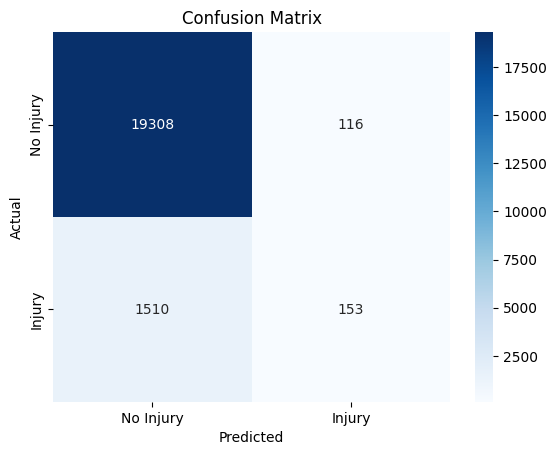

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     19424
           1       0.57      0.09      0.16      1663

    accuracy                           0.92     21087
   macro avg       0.75      0.54      0.56     21087
weighted avg       0.90      0.92      0.90     21087



In [345]:
# evaluating the model

# accuracy
print(f'Testing Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Training Accuracy: {accuracy_score(y_train, logreg.predict(X_train))}')


# confusion matrix
ConfusionMatrix = confusion_matrix(y_test, y_pred)
sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Injury', 'Injury'], yticklabels=['No Injury', 'Injury'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# classification report
print(classification_report(y_test, y_pred))


In [346]:
# interpretations

importances = np.abs(logreg.coef_[0])

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

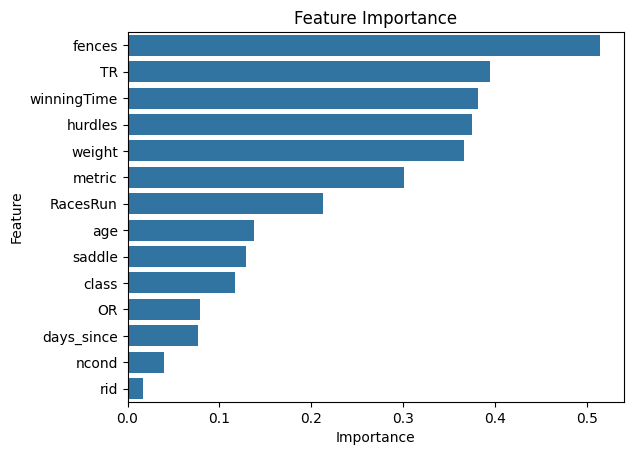

In [347]:
# plot feature importances

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

##### Model Performance Comparison Table

| Model                                   | Training Accuracy | Test Accuracy | Precision (0/1) | Recall (0/1) | F1-Score (0/1) | Macro Avg (F1) | Weighted Avg (F1) | Notes |
|-----------------------------------------|------------------|--------------|----------------|-------------|--------------|----------------|-----------------|-------|
| **Basic Logistic Regression**          | 0.8262           | 0.9229       | 0.93 / 0.57    | 0.99 / 0.09 | 0.96 / 0.16  | 0.56           | 0.90             | High test accuracy but poor recall for class 1 (underfitting to minority class). |


In [348]:
# gridsearch

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print("Best C:", grid_search.best_params_)

Best C: {'C': 0.01}


In [349]:
# cross validation

scores = cross_val_score(LogisticRegression(), X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

Cross-validation scores: [0.92145821 0.92139893 0.92222881 0.92204636 0.92145355]
Mean cross-validation score: 0.9217171724945


In [351]:
# update the model

logreg2 = LogisticRegression(class_weight='balanced' , C=0.01 , random_state=7)
logreg2.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01, class_weight='balanced', random_state=7)

In [352]:
# balanced model

y_pred = logreg2.predict(X_test_scaled)

In [353]:
# balanced classes score

print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)}")
print(f'Training Accuracy: {accuracy_score(y_train, logreg2.predict(X_train))}')


Testing Accuracy: 0.7567695736709821
Training Accuracy: 0.7190923317683882


/opt/anaconda3/envs/capstone_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


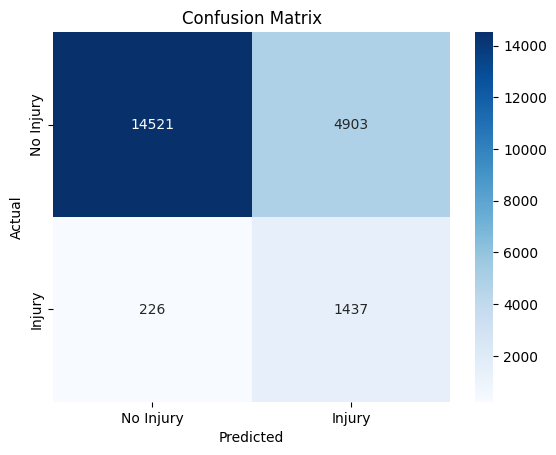

              precision    recall  f1-score   support

           0       0.98      0.75      0.85     19424
           1       0.23      0.86      0.36      1663

    accuracy                           0.76     21087
   macro avg       0.61      0.81      0.60     21087
weighted avg       0.92      0.76      0.81     21087



In [354]:
# confusion matrix
ConfusionMatrix = confusion_matrix(y_test, y_pred)
sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Injury', 'Injury'], yticklabels=['No Injury', 'Injury'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# classification report
print(classification_report(y_test, y_pred))

##### Model Performance Comparison Table

| Model                                   | Training Accuracy | Test Accuracy | Precision (0/1) | Recall (0/1) | F1-Score (0/1) | Macro Avg (F1) | Weighted Avg (F1) | Notes |
|-----------------------------------------|------------------|--------------|----------------|-------------|--------------|----------------|-----------------|-------|
| **Basic Logistic Regression**          | 0.8262           | 0.9229       | 0.93 / 0.57    | 0.99 / 0.09 | 0.96 / 0.16  | 0.56           | 0.90             | High test accuracy but poor recall for class 1 (underfitting to injured class). |
| **LogReg 2 (Grid Search C Params)**    | 0.7191           | 0.7568       | 0.98 / 0.23    | 0.75 / 0.86 | 0.85 / 0.36  | 0.60           | 0.81             | Improved recall for class 1 but lower overall accuracy. |


#### <a id='toc1_2_3_2_'></a>[Random Forest: Classification Model Predicting Risk of Injury (focused on class = 1)](#toc0_)

In [356]:
# create a random forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=7) 
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=7)

In [357]:
# predict

y_pred = rf_model.predict(X_test_scaled)

In [358]:
# accuracy 

print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Training Accuracy: {accuracy_score(y_train, rf_model.predict(X_train_scaled))}")

Testing Accuracy: 0.9516763882961066
Training Accuracy: 0.999976288708683


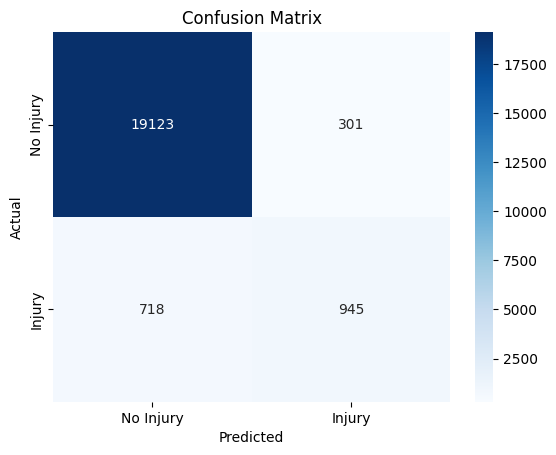

In [359]:
# confusion matrix

ConfusionMatrix = confusion_matrix(y_test, y_pred)
sns.heatmap(ConfusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Injury', 'Injury'], yticklabels=['No Injury', 'Injury'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [360]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     19424
           1       0.76      0.57      0.65      1663

    accuracy                           0.95     21087
   macro avg       0.86      0.78      0.81     21087
weighted avg       0.95      0.95      0.95     21087



In [361]:
# feature importance

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

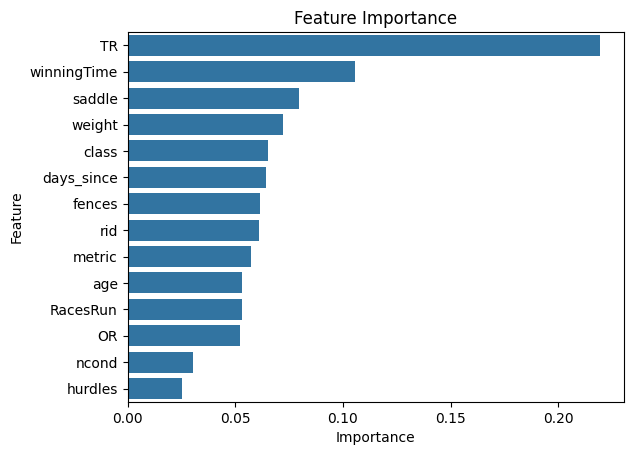

In [362]:
# plot feature importances

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

##### Model Performance Comparison Table

| Model                                   | Training Accuracy | Test Accuracy | Precision (0/1) | Recall (0/1) | F1-Score (0/1) | Macro Avg (F1) | Weighted Avg (F1) | Notes |
|-----------------------------------------|------------------|--------------|----------------|-------------|--------------|----------------|-----------------|-------|
| **Basic Logistic Regression**          | 0.8262           | 0.9229       | 0.93 / 0.57    | 0.99 / 0.09 | 0.96 / 0.16  | 0.56           | 0.90             | High test accuracy but poor recall for class 1 (underfitting to injured class). |
| **LogReg 2 (Grid Search C Params)**    | 0.7191           | 0.7568       | 0.98 / 0.23    | 0.75 / 0.86 | 0.85 / 0.36  | 0.60           | 0.81             | Improved recall for class 1 but lower overall accuracy. |
| **Standard Random Forest**             | 0.99998          | 0.95168       | 0.96 / 0.76    | 0.98 / 0.57 | 0.97 / 0.65  | 0.81           | 0.95             | Severe overfitting and low injury recall, thus it misses too many cases injured cases. |

In [364]:
# gridsearch

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

KeyboardInterrupt: 

In [365]:
# random forest with best params 
rf_model = RandomForestClassifier(n_estimators=200, random_state=7 , max_depth=20 , min_samples_leaf=2 , min_samples_split=5) 
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=7)

In [366]:
# predict

y_pred = rf_model.predict(X_test_scaled)

In [367]:
# testing accuracy

print(f"Testing Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Training Accuracy: {accuracy_score(y_train, rf_model.predict(X_train))}")

Testing Accuracy: 0.9531939109403899


/opt/anaconda3/envs/capstone_env/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Training Accuracy: 0.9234006734006734


In [368]:
# classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     19424
           1       0.78      0.56      0.65      1663

    accuracy                           0.95     21087
   macro avg       0.87      0.77      0.81     21087
weighted avg       0.95      0.95      0.95     21087



##### Model Performance Comparison Table

| Model                                   | Training Accuracy | Test Accuracy | Precision (0/1) | Recall (0/1) | F1-Score (0/1) | Macro Avg (F1) | Weighted Avg (F1) | Notes |
|-----------------------------------------|------------------|--------------|----------------|-------------|--------------|----------------|-----------------|-------|
| **Basic Logistic Regression**          | 0.8262           | 0.9229       | 0.93 / 0.57    | 0.99 / 0.09 | 0.96 / 0.16  | 0.56           | 0.90             | High test accuracy but poor recall for class 1 (underfitting to injured class). |
| **LogReg 2 (Grid Search C Params)**    | 0.7191           | 0.7568       | 0.98 / 0.23    | 0.75 / 0.86 | 0.85 / 0.36  | 0.60           | 0.81             | Improved recall for class 1 but lower overall accuracy. |
| **Standard Random Forest**             | 0.99998          | 0.95168       | 0.96 / 0.76    | 0.98 / 0.57 | 0.97 / 0.65  | 0.81           | 0.95             | Severe overfitting and low injury recall, thus it misses too many cases injured cases. |
| **Random Forest 2 (Grid Search Params)** | 0.9234           | 0.9532       | 0.96 / 0.78    | 0.99 / 0.56 | 0.97 / 0.65  | 0.81           | 0.95             | Strong accuracy, better injury recall than standard random forest, but still misses cases. |


#### Conclusion: Interpretations and Important Findings for Sprint 2

**Interpreations of Models:**
- The **basic logistic regression** model has high overall accuracy but struggles with class 1 recall.
- The **grid-searched logistic regression** improves recall for class 1 but is damaged in overall accuracy.
- The **standard random forest** overfits greatly with its' training accuracy.
- The **grid-searched random forest** improves the standard random forest, but still lacks greatly in recall for injured classes.

My goal for this model is to be able to predict and thus prevent horse injuries. Because of this, I want a model that maximizes recall for class 1 (injury cases)—even if that means the losing some accuracy.

**LogReg 2 (Grid Search C Params)** has the highest recall for class 1 at 0.86, meaning it catches 86% of injured horses. Random Forest 2, despite it being more balanced, only has a recall of 0.56, meaning it misses more injury cases. LogReg 2 also has less overfitting making it a more reliable model for us. 

To further improve our model for sprint 3:
- adjust class weights to give even more importance to injuries.
- work with other models like XG Boost or including SMOTE to handle class imbalance.
- continue to elaborate on EDA if needed.


In [370]:
# pickleing my best model (logreg2)

import pickle

with open("logreg2.pkl", "wb") as file:
    pickle.dump(logreg2, file)